# Nasdaq Index Prediction and Investment Simulation

**Math 178 Final Project**

## Abstract

### Dataset: Nasdaq Index

The dataset is from UCI Machine Learning Repository.

Link: https://archive.ics.uci.edu/dataset/554/cnnpred+cnn+based+stock+market+prediction+using+a+diverse+set+of+variables

"This dataset contains several daily features of S&P 500, NASDAQ Composite, Dow Jones Industrial Average, RUSSELL 2000, and NYSE Composite from 2010 to 2017......It covers features from various categories of technical indicators, futures contracts, price of commodities, important indices of markets around the world, price of major companies in the U.S. market, and treasury bill rates." [1]

For this project, we only use the "NASDAQ Composite" part of this dataset.

### Objectives

The goal of this project is predicting the future Nasdaq Composite Index (COMP) using historical data by machine learning and deep learning models.

Particularly, we have two goals:

1. Predicting the value of Nasdaq Index of the next day given historical data.
2. Conducting an investment simulation by predicting increasing or decreasing trend of Nasdaq Index of the next day.

### Methods

First, we cleaned the data, did basic feature engineering, implemented exploratory data visulization, and made baseline models in section 1. Then, we used a variety of regression models to try to predict the values of future Nasdaq Index, respectively. Also, we implemented some feature selection methods and optimized the hyperparameters to improve the performance of the models.

* Regression Models (Section 2-4): Linear Regression, Tree Based Models (Decision Tree, Random Forest, XGBoost), MLP, LSTM, 1DCNN, CNN LSTM
* Feature Selection Method: Recursive Feature Elimination (RFE)

Finally, in section 5, we evaluated and compared the accuracy of the different models on the testing data and implement an investment simulation to evaluate the profitabilities of these models.

### Results

Because the noise of data is high and the test data is deviated from the training data, it is very hard to make precise predictions. The performance of all the models we trained are not very good, which are even worse than the baseline model. This result is expected. It reflects the complexity of the financial market. More advanced model and more significant features might be helpful to improve the prediction.

## 1. Data Preparation

### 1.1 Exploratory data analysis and data preprocessing

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import joblib
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Firstly, we take a look at the columns and the dataset.

In [2]:
# Load the dataset.
FILE_PATH = "Processed_NASDAQ.csv"
df = pd.read_csv(FILE_PATH)

# Display the data.
print(df)

            Date        Close    Volume       mom      mom1      mom2  \
0     2009-12-31  2269.149902       NaN       NaN       NaN       NaN   
1     2010-01-04  2308.419922  0.560308  0.017306       NaN       NaN   
2     2010-01-05  2308.709961  0.225994  0.000126  0.017306       NaN   
3     2010-01-06  2301.090088 -0.048364 -0.003300  0.000126  0.017306   
4     2010-01-07  2300.050049  0.007416 -0.000452 -0.003300  0.000126   
...          ...          ...       ...       ...       ...       ...   
1979  2017-11-09  6750.049805  0.058830 -0.005755  0.003153 -0.002750   
1980  2017-11-10  6750.939941 -0.116863  0.000132 -0.005755  0.003153   
1981  2017-11-13  6757.600098 -0.000091  0.000987  0.000132 -0.005755   
1982  2017-11-14  6737.870117  0.005087 -0.002920  0.000987  0.000132   
1983  2017-11-15  6706.209961 -0.037891 -0.004699 -0.002920  0.000987   

          mom3     ROC_5    ROC_10    ROC_15  ...   NZD  silver-F  RUSSELL-F  \
0          NaN       NaN       NaN       Na

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1984 non-null   object 
 1   Close           1984 non-null   float64
 2   Volume          1983 non-null   float64
 3   mom             1983 non-null   float64
 4   mom1            1982 non-null   float64
 5   mom2            1981 non-null   float64
 6   mom3            1980 non-null   float64
 7   ROC_5           1979 non-null   float64
 8   ROC_10          1974 non-null   float64
 9   ROC_15          1969 non-null   float64
 10  ROC_20          1964 non-null   float64
 11  EMA_10          1975 non-null   float64
 12  EMA_20          1965 non-null   float64
 13  EMA_50          1935 non-null   float64
 14  EMA_200         1785 non-null   float64
 15  DTB4WK          1984 non-null   float64
 16  DTB3            1984 non-null   float64
 17  DTB6            1984 non-null   f

As we can see, there are a lot of null values. We try to fill these null values to keep as many samples as possible. Considering the nature of time-series prediction, it is important to avoid leaking the future data when we fill these values. So, we don't choose the methods filling backward or filling the mean values which involves using future values to fill the past. Instead, we utilize approaches including filling forward and dropping null values.

In [4]:
# EMA_200 contains too many null values.
# Dropping these rows would lose a lot of data, and filling them could distort the data pattern.
# Therefore, we choose to drop this feature.
df = df.drop(columns=['EMA_200'], errors='ignore')

# Fill forward missing values and then drop any remaining null values.
df = df.ffill()
df = df.dropna()

print(df)


            Date        Close    Volume       mom      mom1      mom2  \
49    2010-03-15  2362.209961 -0.067949 -0.002302 -0.000338  0.004031   
50    2010-03-16  2378.010010  0.125608  0.006689 -0.002302 -0.000338   
51    2010-03-17  2389.090088  0.036119  0.004659  0.006689 -0.002302   
52    2010-03-18  2391.280029 -0.047493  0.000917  0.004659  0.006689   
53    2010-03-19  2374.409912  0.406201 -0.007055  0.000917  0.004659   
...          ...          ...       ...       ...       ...       ...   
1979  2017-11-09  6750.049805  0.058830 -0.005755  0.003153 -0.002750   
1980  2017-11-10  6750.939941 -0.116863  0.000132 -0.005755  0.003153   
1981  2017-11-13  6757.600098 -0.000091  0.000987  0.000132 -0.005755   
1982  2017-11-14  6737.870117  0.005087 -0.002920  0.000987  0.000132   
1983  2017-11-15  6706.209961 -0.037891 -0.004699 -0.002920  0.000987   

          mom3     ROC_5    ROC_10    ROC_15  ...   NZD  silver-F  RUSSELL-F  \
49    0.007805  1.286334  3.898710  5.36031

**Feature Processing and Feature Expansion**

1. Create three date-related features.
2. The 'Close' (Nasdaq Composite Index) and 'EMA' (Exponential Moving Average) features are numerical values, but most of the other features are rate of change (ROC). It doesn't make sense to use ROC to predict a numerical value, especially for linear models. (For example, from 5000 to 6000, the ROC is 0.2. From 1000 to 2000, the ROC is 1.) Therefore, we converge the 'Close' and 'EMA' features to rate of change.
3. We insert the ```t-1``` to ```t-k``` days data to every `t` day's row by creating new columns.
4. Sqaure all the features to create new features to enhance non-linearity capture and highlight volatility effects.

In [5]:
import pandas as pd

# Convert the 'Date' column to datetime format.
df['Date'] = pd.to_datetime(df['Date'])

# Create new features:
# 1. Day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['Date'].dt.dayofweek

# 2. Day of the month
df['day_of_month'] = df['Date'].dt.day

# 3. Month as a number
df['month'] = df['Date'].dt.month

# Compute the rate of change (as a decimal, not a percentage)
df['Close_ROC'] = df['Close'].pct_change()
df['EMA10_ROC'] = df['EMA_10'].pct_change()
df['EMA20_ROC'] = df['EMA_20'].pct_change()
df['EMA50_ROC'] = df['EMA_50'].pct_change()

# Save a copy of the original DataFrame.
df_raw = df.copy()

# Drop non-numeric columns.
df = df.drop(columns=['Date', 'Name'], errors='ignore')

# Drop the first row because the rate of change doesn't apply to it.
df = df.dropna()

# Save the list of original columns (before adding lag features).
original_cols = df.columns.tolist()

# Number of previous days to include.
k = 5

# For each lag (from 1 to k), create new columns by shifting the original columns and
# create squared features for each lagged column.
for i in range(1, k + 1):
    for col in original_cols:
        lagged_col = f'{col}_day-{i}'
        squared_col = f'{lagged_col}^2'
        df[lagged_col] = df[col].shift(i)
        df[squared_col] = df[lagged_col] ** 2

# Drop rows with NaN values resulting from shifting.
df = df.dropna()

print(df)

C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lagged_col] = df[col].shift(i)
C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[squared_col] = df[lagged_col] ** 2
C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

            Close    Volume       mom      mom1      mom2      mom3     ROC_5  \
55    2415.239990  0.006985  0.008283  0.008840 -0.007055  0.000917  1.565594   
56    2398.760010 -0.011816 -0.006823  0.008283  0.008840 -0.007055  0.404753   
57    2397.409912  0.110328 -0.000563 -0.006823  0.008283  0.008840  0.256343   
58    2395.129883 -0.124568 -0.000951 -0.000563 -0.006823  0.008283  0.872637   
59    2404.360107 -0.168958  0.003854 -0.000951 -0.000563 -0.006823  0.374059   
...           ...       ...       ...       ...       ...       ...       ...   
1979  6750.049805  0.058830 -0.005755  0.003153 -0.002750  0.003252  0.522862   
1980  6750.939941 -0.116863  0.000132 -0.005755  0.003153 -0.002750 -0.199573   
1981  6757.600098 -0.000091  0.000987  0.000132 -0.005755  0.003153 -0.424963   
1982  6737.870117  0.005087 -0.002920  0.000987  0.000132 -0.005755 -0.441942   
1983  6706.209961 -0.037891 -0.004699 -0.002920  0.000987  0.000132 -1.221221   

        ROC_10    ROC_15   

C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lagged_col] = df[col].shift(i)
C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[squared_col] = df[lagged_col] ** 2
C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3073063491.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [6]:
df

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,month_day-5,month_day-5^2,Close_ROC_day-5,Close_ROC_day-5^2,EMA10_ROC_day-5,EMA10_ROC_day-5^2,EMA20_ROC_day-5,EMA20_ROC_day-5^2,EMA50_ROC_day-5,EMA50_ROC_day-5^2
55,2415.239990,0.006985,0.008283,0.008840,-0.007055,0.000917,1.565594,3.185402,5.894885,9.117033,...,3.0,9.0,0.006689,4.473834e-05,0.003607,0.000013,0.003339,0.000011,0.002181,0.000005
56,2398.760010,-0.011816,-0.006823,0.008283,0.008840,-0.007055,0.404753,1.687618,5.177407,7.283873,...,3.0,9.0,0.004659,2.170992e-05,0.003802,0.000014,0.003468,0.000012,0.002284,0.000005
57,2397.409912,0.110328,-0.000563,-0.006823,0.008283,0.008840,0.256343,1.222311,4.584888,7.304113,...,3.0,9.0,0.000917,8.402331e-07,0.003268,0.000011,0.003217,0.000010,0.002227,0.000005
58,2395.129883,-0.124568,-0.000951,-0.000563,-0.006823,0.008283,0.872637,1.160216,2.956553,7.008563,...,3.0,9.0,-0.007055,4.977088e-05,0.001364,0.000002,0.002209,0.000005,0.001843,0.000003
59,2404.360107,-0.168958,0.003854,-0.000951,-0.000563,-0.006823,0.374059,1.784352,3.093639,5.752628,...,3.0,9.0,0.008840,7.814714e-05,0.002731,0.000007,0.002854,0.000008,0.002130,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,6750.049805,0.058830,-0.005755,0.003153,-0.002750,0.003252,0.522862,2.947790,2.194980,2.405216,...,11.0,121.0,-0.000237,5.602981e-08,0.001613,0.000003,0.001461,0.000002,0.001191,0.000001
1980,6750.939941,-0.116863,0.000132,-0.005755,0.003153,-0.002750,-0.199573,0.741356,1.838727,2.197162,...,11.0,121.0,0.007372,5.434081e-05,0.002668,0.000007,0.002031,0.000004,0.001441,0.000002
1981,6757.600098,-0.000091,0.000987,0.000132,-0.005755,0.003153,-0.424963,0.875362,2.592598,2.016910,...,11.0,121.0,0.003252,1.057747e-05,0.002775,0.000008,0.002150,0.000005,0.001514,0.000002
1982,6737.870117,0.005087,-0.002920,0.000987,0.000132,-0.005755,-0.441942,0.151616,2.113229,1.724273,...,11.0,121.0,-0.002750,7.560430e-06,0.001758,0.000003,0.001674,0.000003,0.001341,0.000002


### 1.2 Data standardization and train test split

We use the historical data to predict the future data. Therefore, we use ```lagged_cols``` as predictors.

In [7]:
# Filter out the lagged columns.
lagged_cols = [col for col in df.columns if '_day-' in col]
print("Input Features:", lagged_cols)

# Define target variable.
target_var_regression = 'Close_ROC'

# Define X and y.
X = df[lagged_cols]
y = df[target_var_regression]

# Standardize features using StandardScaler.
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Split the data into training and testing sets.
split_ratio = 0.8  # 80% train data, 20% test data
split_index = int(len(df) * split_ratio)
X_train = X_scaled.iloc[:split_index]
X_test = X_scaled.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(X_train)

Input Features: ['Close_day-1', 'Close_day-1^2', 'Volume_day-1', 'Volume_day-1^2', 'mom_day-1', 'mom_day-1^2', 'mom1_day-1', 'mom1_day-1^2', 'mom2_day-1', 'mom2_day-1^2', 'mom3_day-1', 'mom3_day-1^2', 'ROC_5_day-1', 'ROC_5_day-1^2', 'ROC_10_day-1', 'ROC_10_day-1^2', 'ROC_15_day-1', 'ROC_15_day-1^2', 'ROC_20_day-1', 'ROC_20_day-1^2', 'EMA_10_day-1', 'EMA_10_day-1^2', 'EMA_20_day-1', 'EMA_20_day-1^2', 'EMA_50_day-1', 'EMA_50_day-1^2', 'DTB4WK_day-1', 'DTB4WK_day-1^2', 'DTB3_day-1', 'DTB3_day-1^2', 'DTB6_day-1', 'DTB6_day-1^2', 'DGS5_day-1', 'DGS5_day-1^2', 'DGS10_day-1', 'DGS10_day-1^2', 'Oil_day-1', 'Oil_day-1^2', 'Gold_day-1', 'Gold_day-1^2', 'DAAA_day-1', 'DAAA_day-1^2', 'DBAA_day-1', 'DBAA_day-1^2', 'GBP_day-1', 'GBP_day-1^2', 'JPY_day-1', 'JPY_day-1^2', 'CAD_day-1', 'CAD_day-1^2', 'CNY_day-1', 'CNY_day-1^2', 'AAPL_day-1', 'AAPL_day-1^2', 'AMZN_day-1', 'AMZN_day-1^2', 'GE_day-1', 'GE_day-1^2', 'JNJ_day-1', 'JNJ_day-1^2', 'JPM_day-1', 'JPM_day-1^2', 'MSFT_day-1', 'MSFT_day-1^2', 'WFC_

### 1.3 Exploratory data visualization

#### 1.3.1 Dimension reduction method and probability density curves

Here, we used ```UMAP``` and Probability Density Curves to visualize the train and test data.

```UMAP``` is a dimension reduction method by which we can visualize the high dimensional data in a 2-D graph.

We can see that the distribution of train and test data are different. Therefore, we assume that training a good model tends to be hard for this dataset.

C:\Users\zln92\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


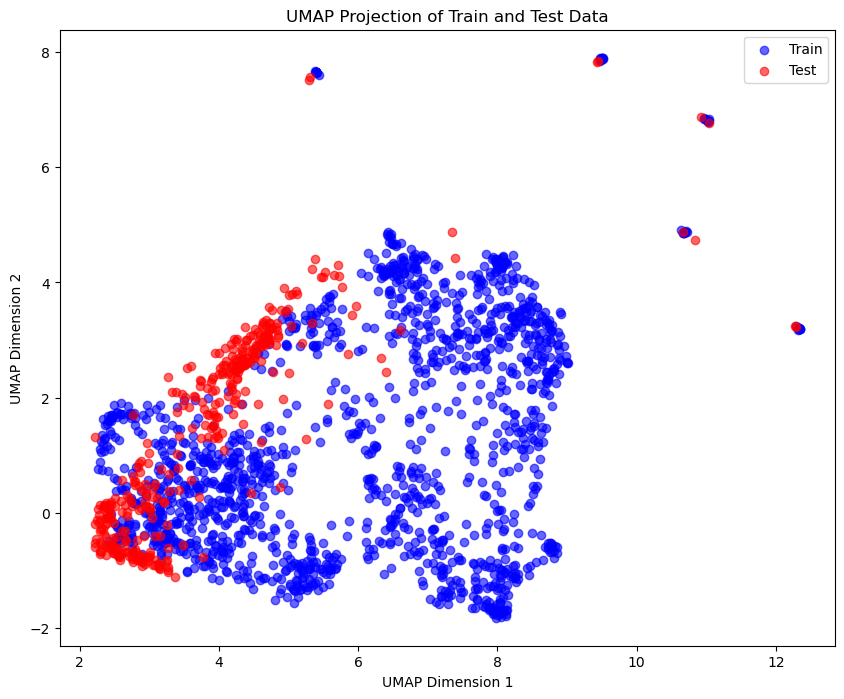

In [8]:
# Initialize the UMAP model (using a fixed random state for reproducibility).
umap_model = UMAP(n_components=2, random_state=42)

# Fit UMAP on the training data and transform both training and test data.
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

# Plot the UMAP projection.
plt.figure(figsize=(10, 8))
plt.scatter(
    X_train_umap[:, 0],
    X_train_umap[:, 1],
    c='blue',
    label='Train',
    alpha=0.6
)
plt.scatter(
    X_test_umap[:, 0],
    X_test_umap[:, 1],
    c='red',
    label='Test',
    alpha=0.6
)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Train and Test Data')
plt.legend()
plt.show()

C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3388851737.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, label="Train", color="blue", shade=True)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\zln92\AppData\Local\Temp\ipykernel_9188\3388851737.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Test", color="red", shade=True)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conve

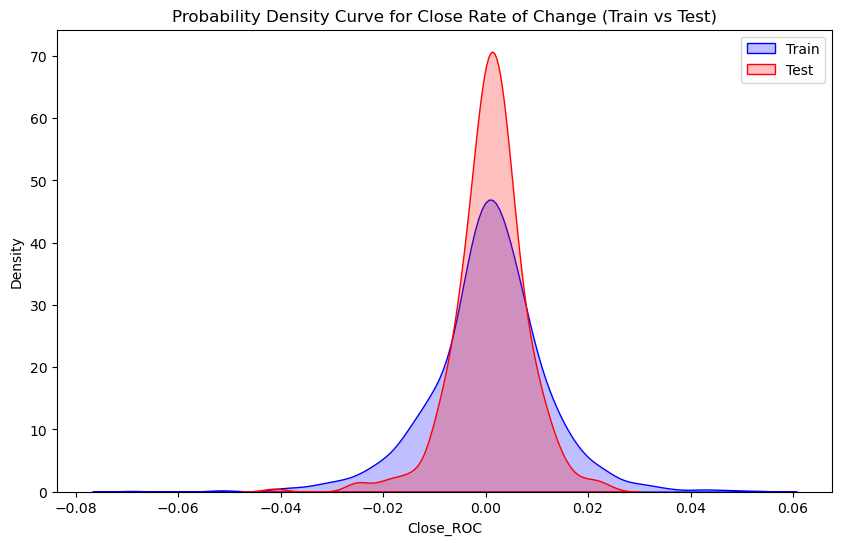

In [9]:
plt.figure(figsize=(10, 6))

sns.kdeplot(y_train, label="Train", color="blue", shade=True)
sns.kdeplot(y_test, label="Test", color="red", shade=True)

plt.xlabel("Close_ROC")
plt.ylabel("Density")
plt.title("Probability Density Curve for Close Rate of Change (Train vs Test)")
plt.legend()

plt.show()

#### 1.3.2 Visualization of "Close_ROC"

We can also see it in another perspective. The daily rate of change of Nasdaq Composite Index looks like noise, which could be hard to predict.

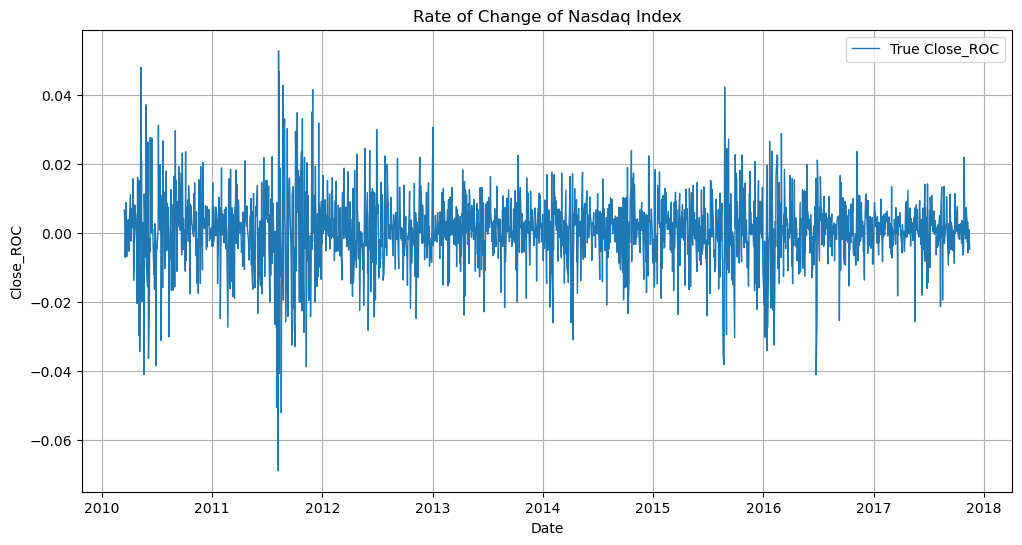

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(
    df_raw["Date"],
    df_raw["Close_ROC"],
    label="True Close_ROC",
    linewidth=1
)

plt.title("Rate of Change of Nasdaq Index")
plt.xlabel("Date")
plt.ylabel("Close_ROC")
plt.legend()
plt.grid(True)
plt.show()

### 1.4 Baseline model

The baseline model is just predict every Nasdaq index value on t day to be the value on t-1 day. It reflects the Martingale in probability theory. [3]

$${\displaystyle \mathbf {E} (\vert X_{n}\vert )<\infty }$$
$$\mathbf {E} (X_{n+1}\mid X_{1},\ldots ,X_{n})=X_{n}.$$

Since we are predicting the value doesn't change from t-1 day to t day, the predicted rate of change ('Close_ROC') of our baseline model is just 0.

In this project, we will use **Root Mean Sqare Error (RMSE)** to evaluate how the predicted value deviate from the true value in a more intuitive way.

In [11]:
# Create baseline predictions (all zeros) for training and test sets.
baseline_train_predict = pd.Series(0, index=range(len(X_train)))
baseline_test_predict = pd.Series(0, index=range(len(X_test)))

# Calculate Mean Squared Error for training and test sets.
baseline_mse_train_final = mean_squared_error(baseline_train_predict, y_train)
baseline_mse_test_final = mean_squared_error(baseline_test_predict, y_test)

# Calculate Root Mean Squared Error.
baseline_rmse_train_final = np.sqrt(baseline_mse_train_final)
baseline_rmse_test_final = np.sqrt(baseline_mse_test_final)

# Print the results.
print("Baseline Regression Model Train MSE:", baseline_mse_train_final)
print("Baseline Regression Model Test MSE:", baseline_mse_test_final)
print("Baseline Regression Model Train RMSE:", baseline_rmse_train_final)
print("Baseline Regression Model Test RMSE:", baseline_rmse_test_final)

Baseline Regression Model Train MSE: 0.0001273147808231767
Baseline Regression Model Test MSE: 5.152090781204474e-05
Baseline Regression Model Train RMSE: 0.01128338516683609
Baseline Regression Model Test RMSE: 0.00717780661567618


## 2. Linear Regression

### 2.1 Linear regression with all the features

Since we have squared features, this is actually polynomial regression. We just treat them as independent features, so we call "linear regression" here.

In [12]:
# Initialize and fit the linear regression model.
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Print training and testing MSE.
train_mse = mean_squared_error(lin_reg.predict(X_train), y_train)
test_mse = mean_squared_error(lin_reg.predict(X_test), y_test)

print("Training mean_squared_error:", train_mse)
print("Testing mean_squared_error:", test_mse)

Training mean_squared_error: 4.631345421141122e-05
Testing mean_squared_error: 0.02637718530839419


In [13]:
# Output model parameters and score.
print("Model coefficients:", lin_reg.coef_)
print("Model intercept:", lin_reg.intercept_)

Model coefficients: [ 2.62057358e+07 -2.96578327e+00 -4.13480215e-04 -2.72071920e-05
 -1.44017558e+05  1.08345848e+05 -3.83533363e+08 -1.91476076e+08
  3.32686386e+08 -3.68066553e+07  1.42758759e+08 -1.02127726e+09
  1.47720671e+00 -3.62809338e-02  2.81973891e-02  1.54078007e-04
  1.03226490e-02  8.03850591e-04  3.86587158e-03 -7.49139115e-04
 -7.99382745e+07  3.06860472e+01 -9.05965750e+07 -4.54048501e+01
 -7.21136865e+07  3.83088106e+01 -4.45410220e+08  6.79812764e-02
  8.55298351e+08 -9.78320895e-02 -5.46330650e+07  7.55610084e-02
 -2.95291096e-03  1.14880130e-02  3.76559227e+08  2.28153099e-01
  2.10749358e-03  1.81356270e-03 -6.28710911e-03 -7.41733983e-03
 -7.72151243e+08 -6.47891592e-02 -3.65905154e+08 -7.72383958e-01
 -2.26842239e-04 -3.40396538e-04  7.73995183e-04 -2.21330673e-04
 -4.31597233e-04 -4.28985804e-04 -6.03104010e-04  4.24114987e-04
 -2.10508704e-04 -4.15660441e-04 -8.28200020e-04 -2.55010091e-04
 -1.24806305e-04 -2.48365104e-05 -8.67899507e-06 -9.38728452e-04
 -3.1

### 2.2 Feature selection for linear regression: Recursive Feature Elimination (RFE)

From above, we can notice that the overfitting occurs. To solve the overfitting, we will try to use fewer features.

Since there are there are too many features, it is too computational expensive to try all the combinations of features. Therefore, we need to select the most important features. We implement Recursive Feature Elimination (RFE) to select the most important features.

#### 2.2.1 Visualization of feature importance

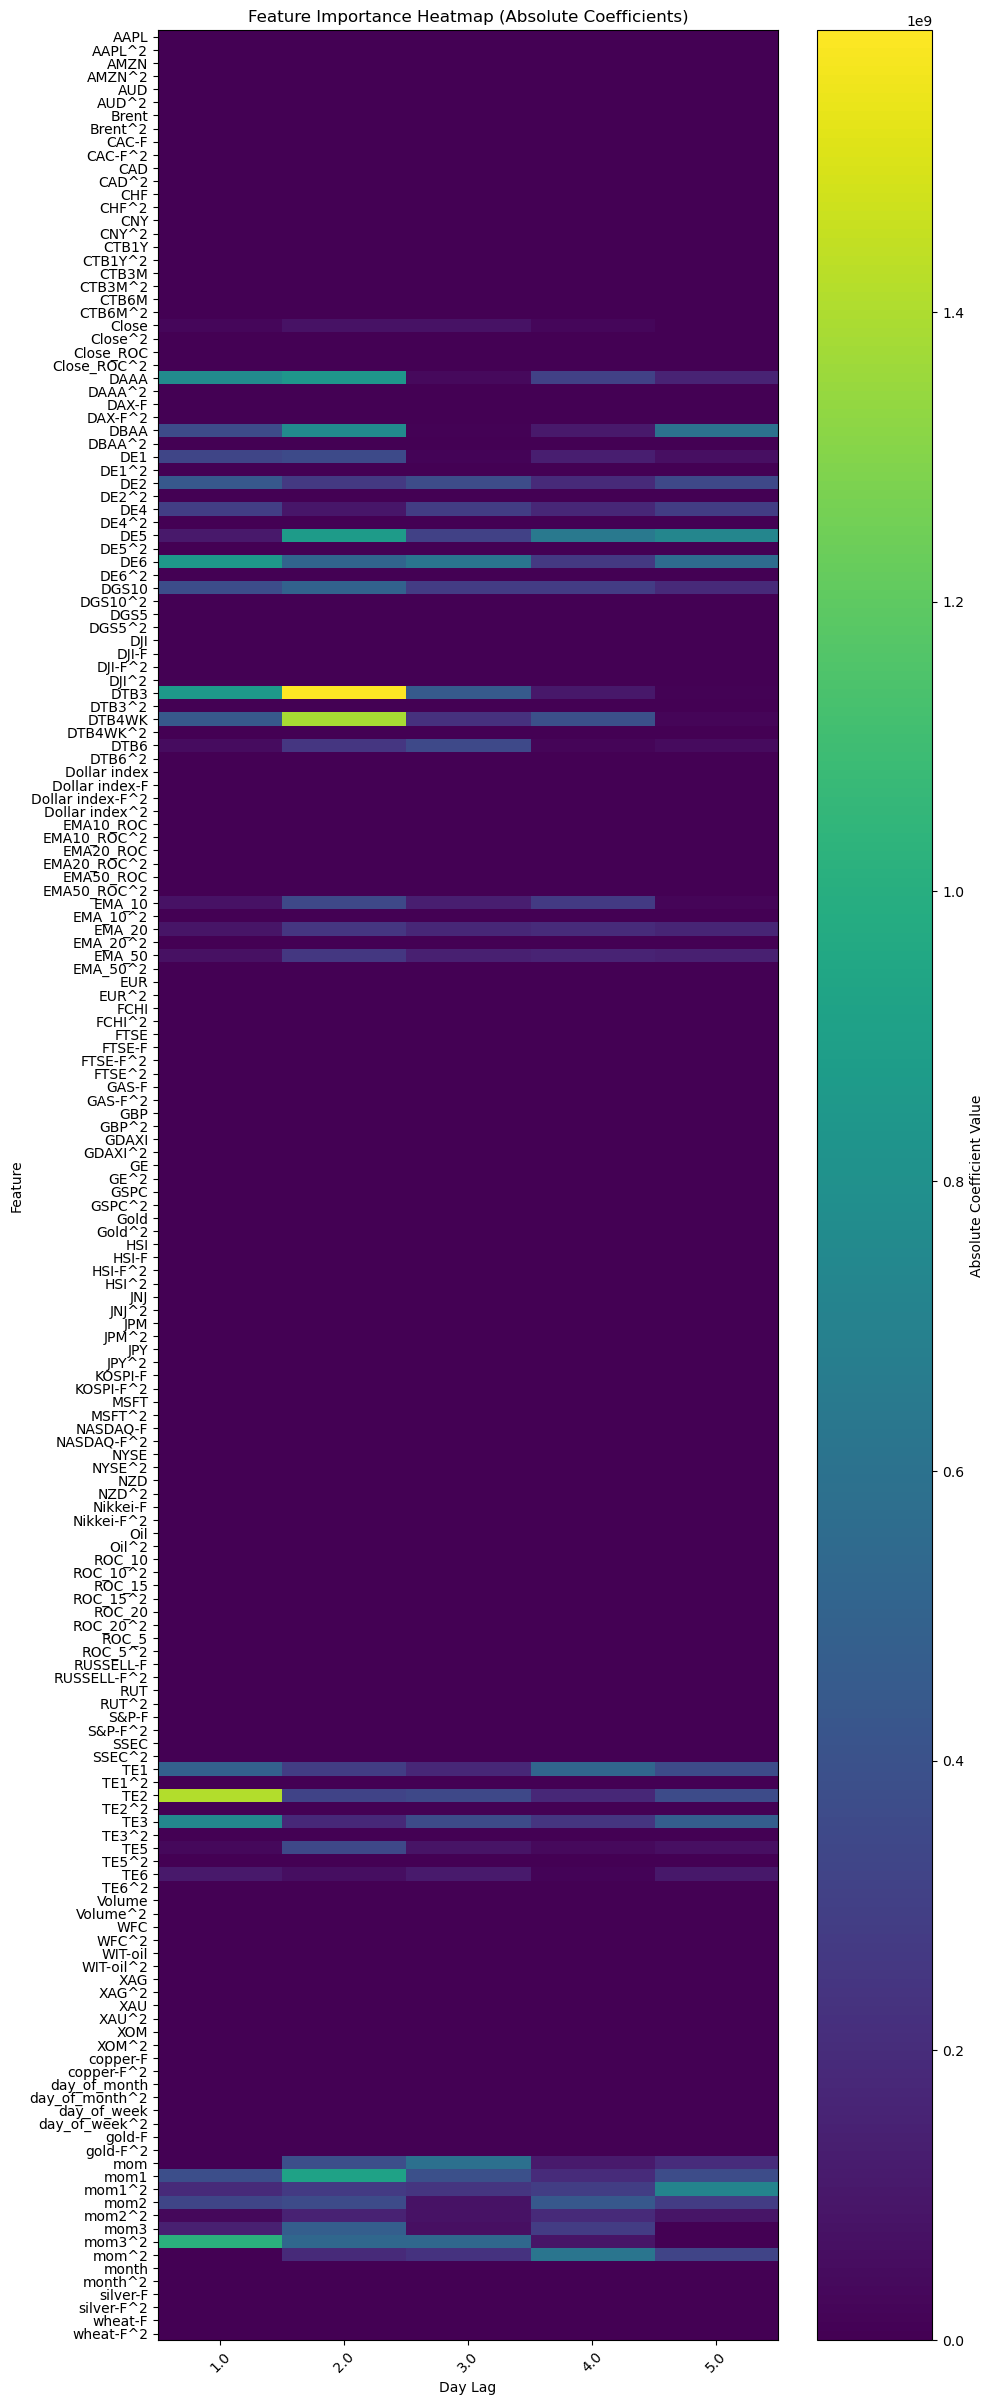

In [14]:
# Assuming `X.columns` contains the feature names and `lin_reg.coef_` contains the coefficients.
df_coef = pd.DataFrame({
    'feature': X.columns,
    'coef': np.abs(lin_reg.coef_)  # Taking absolute values of coefficients
})

df_coef['day'] = df_coef['feature'].str.extract(r'day-(\d+)').astype(float)
df_coef['base_feature'] = df_coef['feature'].str.replace(
    r'_day-\d+(?=\^2)|_day-\d+',
    '',
    regex=True
)

# Group by 'base_feature' and 'day' to ensure uniqueness.
df_coef_grouped = df_coef.groupby(['base_feature', 'day'])['coef'].mean().unstack()

# Plot heatmap.
plt.figure(figsize=(10, 30))
plt.imshow(
    df_coef_grouped,
    aspect='auto',
    cmap='viridis',
    interpolation='nearest'
)
plt.colorbar(label="Absolute Coefficient Value")
plt.xticks(
    ticks=np.arange(len(df_coef_grouped.columns)),
    labels=df_coef_grouped.columns,
    rotation=45
)
plt.yticks(
    ticks=np.arange(len(df_coef_grouped.index)),
    labels=df_coef_grouped.index
)
plt.xlabel("Day Lag")
plt.ylabel("Feature")
plt.title("Feature Importance Heatmap (Absolute Coefficients)")
plt.show()

In [15]:
# Since the 'LinearRegression' object doesn't have 'feature_names_in_', manually retrieve column names.
df_coef = pd.DataFrame({
    'feature': X.columns,
    'coef': lin_reg.coef_
})

chart = alt.Chart(df_coef).mark_bar().encode(
    x='coef',
    y=alt.Y('feature', sort='-x')  # Sort by descending coefficient values.
).properties(
    title='Coefficients'
)

chart

c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

#### 2.2.2 RFE Cross-Validation

We used ```RFECV``` to do RFE and Cross-Validation (CV) at the same time.

In [16]:
# Time Series Cross-Validation.
tscv = TimeSeriesSplit(n_splits=3)

step_lin_reg = 1

# Initialize RFECV.
selector_lin_reg_cv = RFECV(
    estimator=LinearRegression(n_jobs=-1),
    step=step_lin_reg,  # Remove 1 feature at each step.
    cv=tscv,          # Time series split.
    verbose=1,
    scoring='neg_mean_squared_error'  # Negative MSE for scoring.
)

# Train and automatically select the optimal number of features.
selector_lin_reg_cv.fit(X_train, y_train)

# Save the best model for later use.
best_model_reg_final = selector_lin_reg_cv.estimator

Fitting estimator with 880 features.
Fitting estimator with 879 features.
Fitting estimator with 878 features.
Fitting estimator with 877 features.
Fitting estimator with 876 features.
Fitting estimator with 875 features.
Fitting estimator with 874 features.
Fitting estimator with 873 features.
Fitting estimator with 872 features.
Fitting estimator with 871 features.
Fitting estimator with 870 features.
Fitting estimator with 869 features.
Fitting estimator with 868 features.
Fitting estimator with 867 features.
Fitting estimator with 866 features.
Fitting estimator with 865 features.
Fitting estimator with 864 features.
Fitting estimator with 863 features.
Fitting estimator with 862 features.
Fitting estimator with 861 features.
Fitting estimator with 860 features.
Fitting estimator with 859 features.
Fitting estimator with 858 features.
Fitting estimator with 857 features.
Fitting estimator with 856 features.
Fitting estimator with 855 features.
Fitting estimator with 854 features.
F

In [17]:
# Save the model
joblib.dump(selector_lin_reg_cv, "selector_lin_reg_cv.joblib")

['selector_lin_reg_cv.joblib']

As shown in the graph below, as the number of feature decreases, the validation loss tend to decrease.

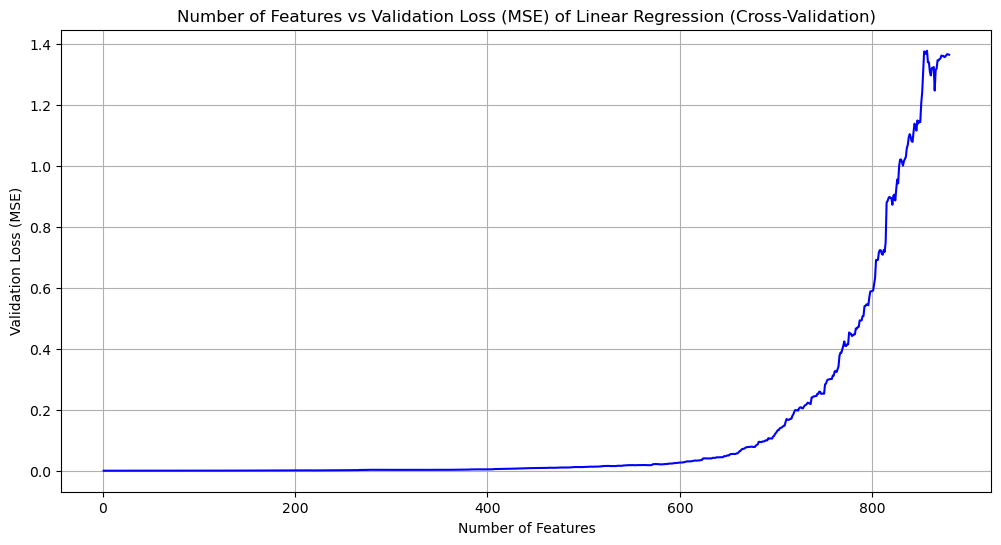

In [18]:
def plot_n_feature_val_loss(selector, step, model_name="", mark=None):
    """
    Plot the validation loss (MSE) versus the number of features used.

    Parameters:
        selector: The RFECV selector containing cv_results_.
        step (int): The step size used in feature elimination.
        model_name (str): Name of the model for title annotation.
        mark: Marker style for the plot.
    """
    # Extract results.
    n_features = np.array(range(1, len(selector.cv_results_["mean_test_score"]) + 1))
    validation_loss = -selector.cv_results_["mean_test_score"]  # Convert to positive MSE.

    # Plot.
    plt.figure(figsize=(12, 6))
    plt.plot(n_features * step, validation_loss, marker=mark, linestyle="-", color="b")
    plt.title(f"Number of Features vs Validation Loss (MSE) of {model_name}")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Loss (MSE)")
    plt.grid(True)
    plt.show()

plot_n_feature_val_loss(
    selector_lin_reg_cv,
    step=step_lin_reg,
    model_name="Linear Regression (Cross-Validation)",
    mark=None
)

In [19]:
def selector_result(selector, X_train_temp=X_train, y_train_temp=y_train,
                    X_test_temp=X_test, y_test_temp=y_test,
                    model_name="", print_out=True, predict=False):
    """
    Evaluate the selected model and print or return performance metrics.

    Parameters:
        selector: The RFECV selector object containing cv_results_ and estimator.
        X_train_temp (DataFrame): Training feature set.
        y_train_temp (Series): Training labels.
        X_test_temp (DataFrame): Testing feature set.
        y_test_temp (Series): Testing labels.
        model_name (str): Name of the model for display purposes.
        print_out (bool): If True, print the metrics.
        predict (bool): If True, return predictions instead of metrics.

    Returns:
        Tuple: (train MSE, test MSE, train RMSE, test RMSE) if predict is False,
               otherwise a list of predictions.
    """
    features = X_train_temp.columns[selector.support_]

    mse_bs_series = pd.Series(-selector.cv_results_["mean_test_score"])

    best_model = selector.estimator
    best_model.fit(X_train_temp[features], y_train_temp)
    best_model_mse_train = mean_squared_error(best_model.predict(X_train_temp[features]),
                                              y_train_temp)
    y_predict = best_model.predict(X_test_temp[features])
    best_model_mse_test = mean_squared_error(best_model.predict(X_test_temp[features]),
                                             y_test_temp)
    best_model_rmse_train = np.sqrt(best_model_mse_train)
    best_model_rmse_test = np.sqrt(best_model_mse_test)

    if print_out:
        print(f"Optimal number of features for {model_name}: {selector.n_features_}")
        print(f"Selected features for Linear {model_name}: {features}")
        print("Best Validation MSE:", mse_bs_series.min())
        print("-----------------------------")
        print(f"Best {model_name} Model Train MSE: {best_model_mse_train}")
        print(f"Best {model_name} Model Test MSE: {best_model_mse_test}")
        print(f"Best {model_name} Model Train RMSE: {best_model_rmse_train}")
        print(f"Best {model_name} Model Test RMSE: {best_model_rmse_test}")

    if not predict:
        return best_model_mse_train, best_model_mse_test, best_model_rmse_train, best_model_rmse_test
    else:
        return list(y_predict)


_ = selector_result(selector_lin_reg_cv, X_train, y_train, X_test, y_test, "Linear Regression (Cross-Validation)")

Optimal number of features for Linear Regression (Cross-Validation): 5
Selected features for Linear Linear Regression (Cross-Validation): Index(['TE3_day-1', 'TE1_day-4', 'TE2_day-4', 'DE5_day-4', 'DE6_day-4'], dtype='object')
Best Validation MSE: 0.00010527116357773034
-----------------------------
Best Linear Regression (Cross-Validation) Model Train MSE: 0.00012614083944832163
Best Linear Regression (Cross-Validation) Model Test MSE: 5.793372382508834e-05
Best Linear Regression (Cross-Validation) Model Train RMSE: 0.011231243895861297
Best Linear Regression (Cross-Validation) Model Test RMSE: 0.007611420618063906


## 3. Tree Based Models for Regression

We implement the same feature selection strategy for tree models

### 3.1 Decision Tree

#### 3.1.1 Feature Selection

In [20]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

step_dt = 1

# Initialize RFECV
selector_dt = RFECV(
    estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
    step=step_dt,  # Remove 1 feature at each step
    cv=tscv,      # Time series split
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'  # Negative MSE for scoring
)

# Train and automatically select optimal number of features
selector_dt.fit(X_train, y_train)

Fitting estimator with 880 features.
Fitting estimator with 879 features.
Fitting estimator with 878 features.
Fitting estimator with 877 features.
Fitting estimator with 876 features.
Fitting estimator with 875 features.
Fitting estimator with 874 features.
Fitting estimator with 873 features.
Fitting estimator with 872 features.
Fitting estimator with 871 features.
Fitting estimator with 870 features.
Fitting estimator with 869 features.
Fitting estimator with 868 features.
Fitting estimator with 867 features.
Fitting estimator with 866 features.
Fitting estimator with 865 features.
Fitting estimator with 864 features.
Fitting estimator with 863 features.
Fitting estimator with 862 features.
Fitting estimator with 861 features.
Fitting estimator with 860 features.
Fitting estimator with 859 features.
Fitting estimator with 858 features.
Fitting estimator with 857 features.
Fitting estimator with 856 features.
Fitting estimator with 855 features.
Fitting estimator with 854 features.
F

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
      estimator=DecisionTreeRegressor(max_depth=10, random_state=42), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [21]:
# Save the model
joblib.dump(selector_dt, "selector_dt.joblib")

['selector_dt.joblib']

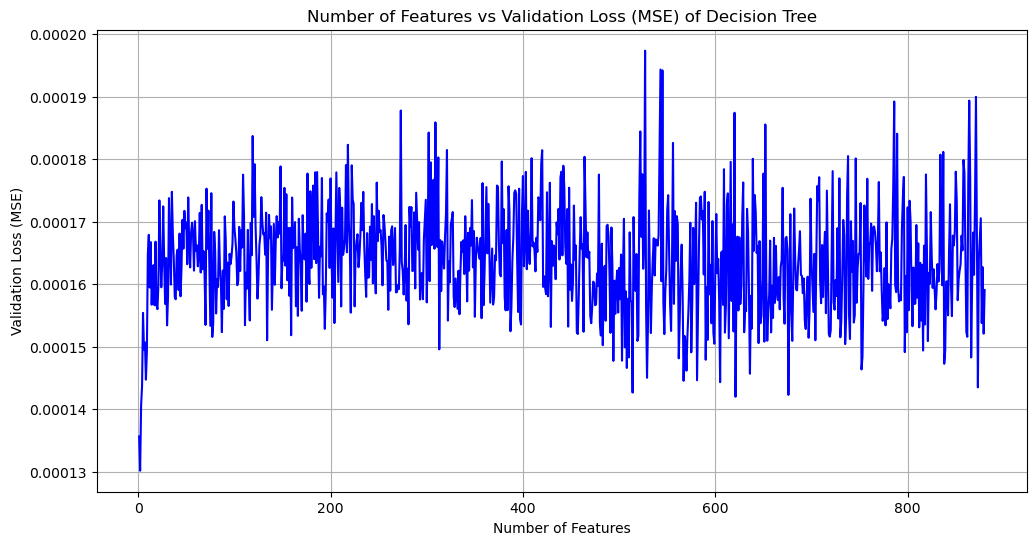

In [22]:
plot_n_feature_val_loss(selector_dt, step=step_dt, model_name='Decision Tree', mark=None)

In [23]:
_ = selector_result(selector_dt, X_train, y_train, X_test, y_test, "Decision Tree")

Optimal number of features for Decision Tree: 2
Selected features for Linear Decision Tree: Index(['ROC_10_day-1', 'NASDAQ-F_day-3'], dtype='object')
Best Validation MSE: 0.00013017646633121612
-----------------------------
Best Decision Tree Model Train MSE: 9.389818141190975e-05
Best Decision Tree Model Test MSE: 5.319664601451538e-05
Best Decision Tree Model Train RMSE: 0.00969010739940016
Best Decision Tree Model Test RMSE: 0.0072936030886329


#### 3.1.2 Hyperparameter Optimization

In [24]:
# Get selected features
X_train_selected_dt = X_train.iloc[:, selector_dt.support_]

# Hyperparameter optimization
param_grid_dt = {
    'max_depth': [2, 3, 4, 6, 8, 10, None],
    'min_samples_split': [2, 3, 4, 6, 8, 10],
}
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)
grid_search_dt.fit(X_train_selected_dt, y_train)


Fitting 3 folds for each of 42 candidates, totalling 126 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 6, 8, 10, None],
                         'min_samples_split': [2, 3, 4, 6, 8, 10]},
             scoring='neg_mean_squared_error', verbose=1)

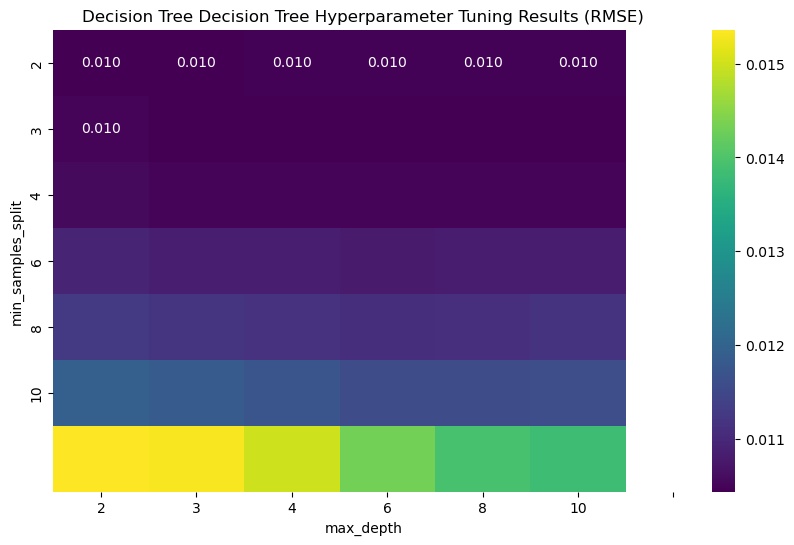

In [25]:
def two_hyperparameter_visualization(grid_search, hp1, hp2, model_name,
                                     criterion='mean_test_score',
                                     criterion_name='RMSE'):
    # Extract results
    results = grid_search.cv_results_
    mean_scores = np.sqrt(-results[criterion])  # Convert to positive RMSE
    param_1 = grid_search.param_grid[hp1]
    param_2 = grid_search.param_grid[hp2]

    # Reshape scores into a matrix
    scores_matrix = np.reshape(mean_scores, (len(param_1), len(param_2)))

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        scores_matrix,
        annot=True,
        fmt=".3f",
        xticklabels=param_1,
        yticklabels=param_2,
        cmap="viridis",
    )
    plt.xlabel(hp1)
    plt.ylabel(hp2)
    plt.title(
        f"{model_name} Decision Tree Hyperparameter Tuning Results "
        f"({criterion_name})"
    )
    plt.show()


two_hyperparameter_visualization(
    grid_search_dt, 'max_depth', 'min_samples_split', 'Decision Tree'
)


In [26]:
# Evaluate the final model
best_model_dt_final = grid_search_dt.best_estimator_
best_model_dt_final.fit(
    X_train[X.columns[selector_dt.support_]], y_train
)

# Save the model
joblib.dump(best_model_dt_final, 'best_model_dt_final.joblib')


def grid_search_result(grid_search, selector, final_model, model_name='', print_out=True):
    best_model_mse_train_final = mean_squared_error(
        final_model.predict(X_train[X.columns[selector.support_]]), y_train
    )
    best_model_mse_test_final = mean_squared_error(
        final_model.predict(X_test[X.columns[selector.support_]]), y_test
    )
    best_model_rmse_train_final = np.sqrt(best_model_mse_train_final)
    best_model_rmse_test_final = np.sqrt(best_model_mse_test_final)

    if print_out:
        print(f"{model_name} Best hyperparameters:", grid_search.best_params_)
        print(f"{model_name} Best Validation MSE:", -grid_search.best_score_)
        print("-----------------------------")
        print(f"{model_name} Best Model Train MSE:", best_model_mse_train_final)
        print(f"{model_name} Best Model Test MSE:", best_model_mse_test_final)
        print(f"{model_name} Best Model Train RMSE:", best_model_rmse_train_final)
        print(f"{model_name} Best Model Test RMSE:", best_model_rmse_test_final)

    return (
        best_model_mse_train_final,
        best_model_mse_test_final,
        best_model_rmse_train_final,
        best_model_rmse_test_final,
    )


_ = grid_search_result(grid_search_dt, selector_dt, best_model_dt_final, 'Decision Tree')


Decision Tree Best hyperparameters: {'max_depth': 3, 'min_samples_split': 3}
Decision Tree Best Validation MSE: 0.00010894315706034298
-----------------------------
Decision Tree Best Model Train MSE: 0.00011617992780627547
Decision Tree Best Model Test MSE: 5.0685852201722405e-05
Decision Tree Best Model Train RMSE: 0.010778679316422558
Decision Tree Best Model Test RMSE: 0.007119399707961508


### 3.2 Random Forest

#### 3.2.1 Feature Selection

Because of the limited computing resource we have, we remove 5 features at each step in the RFE process.

In [27]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

step_rf = 5

# Initialize RFECV, select some hyperparameters
selector_rf = RFECV(
    estimator=RandomForestRegressor(
        n_estimators=30,       # Fewer trees for speed (but not too few)
        max_depth=10,          # Limit tree depth to avoid overfitting
        max_samples=0.6,       # Use 60% of data per tree (balance speed and diversity)
        min_samples_split=10,  # Prevent splits on small nodes
        min_samples_leaf=15,   # Require larger leaves
        max_features='log2',   # log2(800) ≈ 9 features per split (faster than 'sqrt')
        n_jobs=-1,             # Use all CPU cores
        random_state=42,       # Reproducibility
        bootstrap=True,        # Bootstrap sampling for diversity
    ),
    step=step_rf,             # Remove 5 features at each step
    cv=tscv,                  # Time series split
    verbose=1,
    scoring='neg_mean_squared_error'  # Negative MSE for scoring
)

# Train and automatically select optimal number of features
selector_rf.fit(X_train, y_train)


Fitting estimator with 880 features.
Fitting estimator with 875 features.
Fitting estimator with 870 features.
Fitting estimator with 865 features.
Fitting estimator with 860 features.
Fitting estimator with 855 features.
Fitting estimator with 850 features.
Fitting estimator with 845 features.
Fitting estimator with 840 features.
Fitting estimator with 835 features.
Fitting estimator with 830 features.
Fitting estimator with 825 features.
Fitting estimator with 820 features.
Fitting estimator with 815 features.
Fitting estimator with 810 features.
Fitting estimator with 805 features.
Fitting estimator with 800 features.
Fitting estimator with 795 features.
Fitting estimator with 790 features.
Fitting estimator with 785 features.
Fitting estimator with 780 features.
Fitting estimator with 775 features.
Fitting estimator with 770 features.
Fitting estimator with 765 features.
Fitting estimator with 760 features.
Fitting estimator with 755 features.
Fitting estimator with 750 features.
F

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
      estimator=RandomForestRegressor(max_depth=10, max_features='log2',
                                      max_samples=0.6, min_samples_leaf=15,
                                      min_samples_split=10, n_estimators=30,
                                      n_jobs=-1, random_state=42),
      scoring='neg_mean_squared_error', step=5, verbose=1)

In [28]:
# Save the model
joblib.dump(selector_rf, 'selector_rf.joblib')

['selector_rf.joblib']

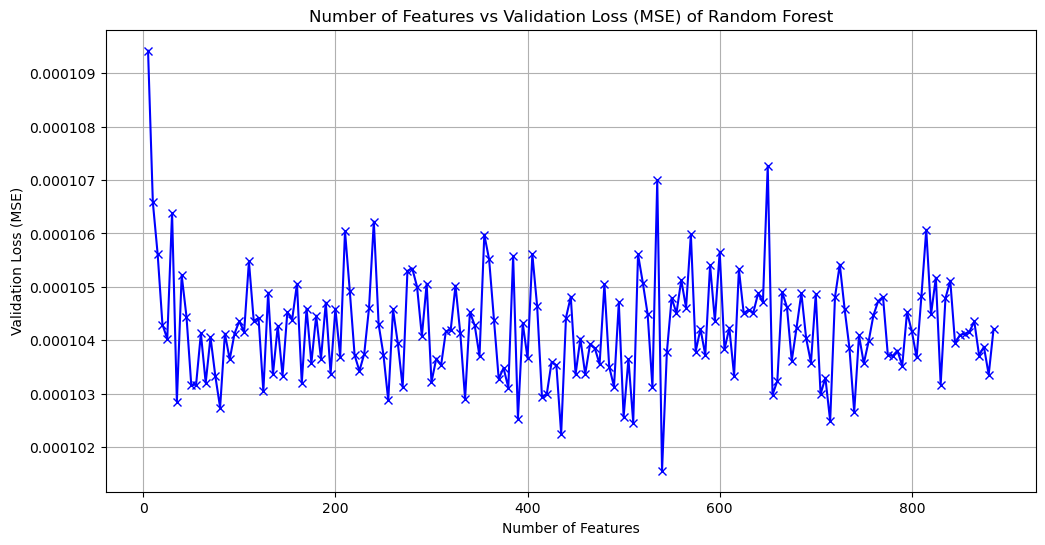

In [29]:
plot_n_feature_val_loss(selector_rf, step=step_rf, model_name='Random Forest', mark='x')

In [30]:
selector_result(selector_rf, X_train, y_train, X_test, y_test, 'Random Forest')

Optimal number of features for Random Forest: 535
Selected features for Linear Random Forest: Index(['ROC_20_day-1', 'ROC_20_day-1^2', 'EMA_10_day-1', 'EMA_10_day-1^2',
       'EMA_20_day-1', 'EMA_20_day-1^2', 'EMA_50_day-1', 'EMA_50_day-1^2',
       'DTB4WK_day-1', 'DTB4WK_day-1^2',
       ...
       'Dollar index-F_day-5^2', 'Dollar index_day-5', 'Dollar index_day-5^2',
       'wheat-F_day-5', 'wheat-F_day-5^2', 'XAG_day-5', 'XAG_day-5^2',
       'XAU_day-5', 'XAU_day-5^2', 'day_of_week_day-5'],
      dtype='object', length=535)
Best Validation MSE: 0.00010155466999754498
-----------------------------
Best Random Forest Model Train MSE: 0.00010452561376682597
Best Random Forest Model Test MSE: 5.417641101158336e-05
Best Random Forest Model Train RMSE: 0.010223776883658307
Best Random Forest Model Test RMSE: 0.007360462690047641


(0.00010452561376682597,
 5.417641101158336e-05,
 0.010223776883658307,
 0.007360462690047641)

#### 3.2.2 Hyperparameter Optimization

In [31]:
# Get selected features
X_train_selected_rf = X_train.iloc[:, selector_rf.support_]

# Hyperparameter optimization
param_grid_rf = {
    'n_estimators': [50, 100, 150],      # Fewer trees than default (balance speed and stability)
    'max_depth': [5, 10, 15],            # Shallower trees to prevent overfitting
    'min_samples_split': [10, 20, 30],   # Larger splits for noisy data
    'min_samples_leaf': [5, 10, 15],     # Larger leaves for regularization
    'max_features': ['log2', 0.05],      # Fewer features per split (critical for high dimensions)
    'bootstrap': [True],               # Bootstrap sampling for robustness
    'max_samples': [0.6, 0.8],           # Subsample data to increase diversity
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
)
grid_search_rf.fit(X_train_selected_rf, y_train)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15],
                         'max_features': ['log2', 0.05],
                         'max_samples': [0.6, 0.8],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=1)

Here's the optimized parameters for random forest.

In [32]:
# Evaluate the final model
best_model_rf_final = grid_search_rf.best_estimator_
best_model_rf_final.fit(X_train[X.columns[selector_rf.support_]], y_train)

# Save the model
joblib.dump(best_model_rf_final, 'best_model_rf_final.joblib')

_ = grid_search_result(grid_search_rf, selector_rf, best_model_rf_final, 'Random Forest')


Random Forest Best hyperparameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'max_samples': 0.8, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Best Validation MSE: 0.00010222025743517132
-----------------------------
Random Forest Best Model Train MSE: 0.00011301699070842933
Random Forest Best Model Test MSE: 5.164476926179037e-05
Random Forest Best Model Train RMSE: 0.010630944958395248
Random Forest Best Model Test RMSE: 0.0071864295211036735


### 3.3 XGBoost

#### 3.3.1 Feature Selection

In [33]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

step_xgb = 5

# Initialize RFECV
selector_xgb = RFECV(
    estimator=XGBRegressor(
        n_estimators=50,  # Number of trees (balance speed and performance)
        max_depth=5,  # Limit tree depth to prevent overfitting
        subsample=0.8,  # Use 80% of samples per tree (introduce diversity)
        min_child_weight=3,  # Minimum sum of instance weights (controls splits)
        tree_method='hist',  # Histogram-based tree method (faster than 'exact')
        device='cuda',  # Use GPU for training (if available)
        random_state=42,  # Reproducibility
        n_jobs=-1  # Use all CPU cores for parallel processing
    ),
    step=step_xgb,  # Remove 5 features at each step
    cv=tscv,  # Time series split
    verbose=1,
    scoring='neg_mean_squared_error'  # Negative MSE for scoring
)

# Train and automatically select optimal number of features
selector_xgb.fit(X_train, y_train)




Fitting estimator with 880 features.


C:\Users\zln92\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 875 features.
Fitting estimator with 870 features.
Fitting estimator with 865 features.
Fitting estimator with 860 features.
Fitting estimator with 855 features.
Fitting estimator with 850 features.
Fitting estimator with 845 features.
Fitting estimator with 840 features.
Fitting estimator with 835 features.
Fitting estimator with 830 features.
Fitting estimator with 825 features.
Fitting estimator with 820 features.
Fitting estimator with 815 features.
Fitting estimator with 810 features.
Fitting estimator with 805 features.
Fitting estimator with 800 features.
Fitting estimator with 795 features.
Fitting estimator with 790 features.
Fitting estimator with 785 features.
Fitting estimator with 780 features.
Fitting estimator with 775 features.
Fitting estimator with 770 features.
Fitting estimator with 765 features.
Fitting estimator with 760 features.
Fitting estimator with 755 features.
Fitting estimator with 750 features.
Fitting estimator with 745 features.
F

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device='cuda',
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, grow_policy=None,
                             importan...teraction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=5, max_leaves=None,
                             min_child_weight=3, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=50, n_jobs=-1, num_parallel_tree=None,
                             random_state=42, ...),
      scoring='neg_mean_squared_error', step=5, verbose=1)

In [34]:
# Save the model
joblib.dump(selector_xgb, 'selector_xgb.joblib')

['selector_xgb.joblib']

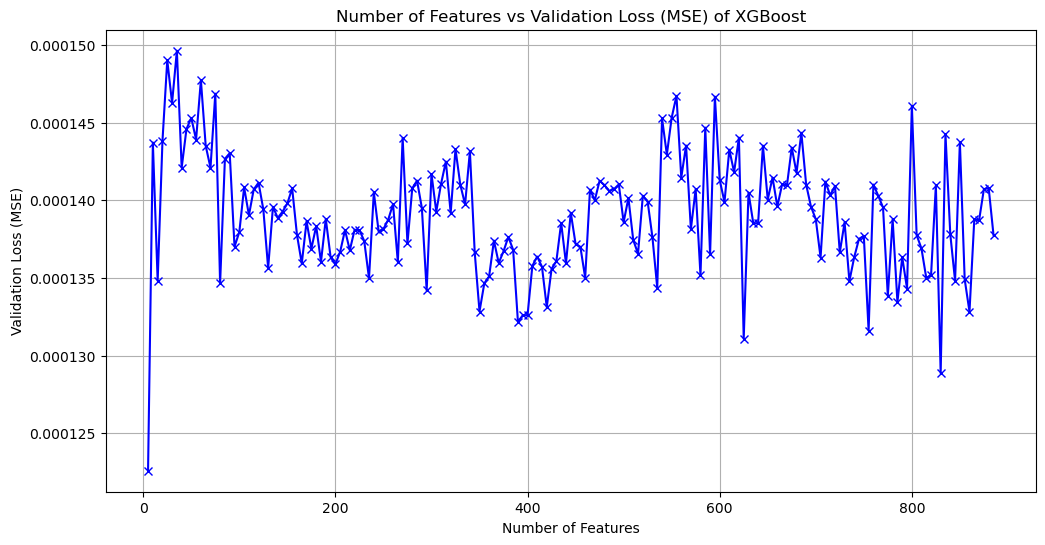

In [35]:
plot_n_feature_val_loss(selector_xgb, step=step_xgb, model_name='XGBoost', mark='x')


In [36]:
selector_result(selector_xgb, X_train, y_train, X_test, y_test, 'XGBoost')


Optimal number of features for XGBoost: 1
Selected features for Linear XGBoost: Index(['ROC_20_day-1'], dtype='object')
Best Validation MSE: 0.00012259275374271517
-----------------------------
Best XGBoost Model Train MSE: 0.00010600596254067053
Best XGBoost Model Test MSE: 5.943372552324083e-05
Best XGBoost Model Train RMSE: 0.010295919703487907
Best XGBoost Model Test RMSE: 0.007709327177078479


(0.00010600596254067053,
 5.943372552324083e-05,
 0.010295919703487907,
 0.007709327177078479)

#### 3.3.2 Hyperparameter Optimization

In [37]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Initialize GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [3, 5, 7],  # Maximum tree depth
    'subsample': [0.8, 1.0],  # Fraction of samples per tree
    'colsample_bytree': [0.6, 1.0],  # Fraction of features per tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction for a split
    'min_child_weight': [3, 5],  # Minimum sum of instance weights
}
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(
        tree_method='hist',  # Use GPU for training
        device='cuda',  # Specify GPU device
        random_state=42,
        n_jobs=-1,  # Enable CPU parallelism (optional, if GPU is not available)
    ),
    param_grid=param_grid_xgb,
    cv=tscv,  # Time series split
    scoring='neg_mean_squared_error',  # Negative MSE for scoring
    verbose=2,  # Print progress
    n_jobs=-1,  # Use all CPU cores
)

# Fit the model
grid_search_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, i...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 1.0], 'gamma': [0, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [38]:
# Evaluate the final model
best_model_xgb_final = grid_search_xgb.best_estimator_
best_model_xgb_final.fit(X_train[X.columns[selector_xgb.support_]], y_train)

# Save the model
joblib.dump(best_model_xgb_final, 'best_model_xgb_final.joblib')


['best_model_xgb_final.joblib']

In [39]:
_ = grid_search_result(grid_search_xgb, selector_xgb, best_model_xgb_final, 'XGBoost')


XGBoost Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best Validation MSE: 0.00010268245284882257
-----------------------------
XGBoost Best Model Train MSE: 0.00012705996490768268
XGBoost Best Model Test MSE: 5.086330269091728e-05
XGBoost Best Model Train RMSE: 0.011272087868167222
XGBoost Best Model Test RMSE: 0.00713185128076275


## 4. Neural Network Models for Regression

Because of the limited computing resource, we didn't implement feature or hyperparameter optimization for Neural Network models. These models are just exploratory attempts.

### 4.1 Multilayer Perceptron

In [40]:
MLP_reg = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(128, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (linear activation)
])

# Compile the model
MLP_reg.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

split_date = int(0.75 * len(X_train))  # 60% training (0.75*80%), 20% validation
X_train_split, X_val = X_train[:split_date], X_train[split_date:]
y_train_split, y_val = y_train[:split_date], y_train[split_date:]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=0,
)

callbacks = [
    early_stopping,
    reduce_lr,
]

# Train the model
history = MLP_reg.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
)


C:\Users\zln92\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 48.4190 - val_loss: 0.0687 - learning_rate: 0.0100
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0241 - learning_rate: 0.0100
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0222 - learning_rate: 0.0100
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7949e-04 - val_loss: 0.0210 - learning_rate: 0.0100
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6575e-04 - val_loss: 0.0201 - learning_rate: 0.0100
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1016e-04 - val_loss: 0.0195 - learning_rate: 0.0100
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6531e-04 - val_loss: 0.0188 - learning_rate: 0.0100
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0890e-04 - val_loss: 0.0184 - learning_rate: 0.0100
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7962e-04 - val_loss: 0.0179 - learning_rate: 

In [41]:
MLP_reg.save('MLP_reg.keras')


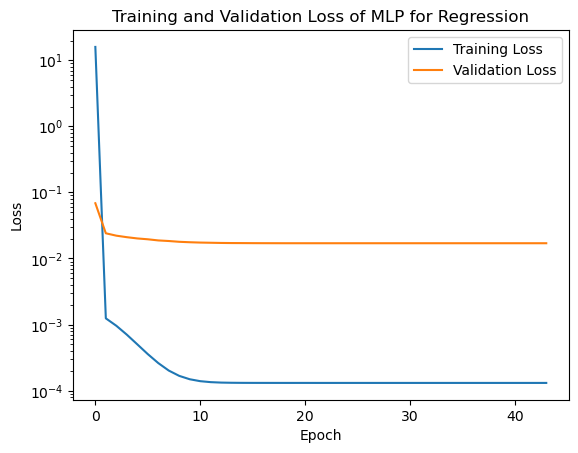

In [42]:
plt.title('Training and Validation Loss of MLP for Regression')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()


In [43]:
# Evaluate the model
def result_nn(model, model_name='', X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test, print_out=True, predict=False):
    train_MSE = model.evaluate(X_tr, y_tr)
    test_MSE = model.evaluate(X_te, y_te)
    train_RMSE = np.sqrt(train_MSE)
    test_RMSE = np.sqrt(test_MSE)
    y_test_predict = model.predict(X_te)
    if print_out:
        print(f'{model_name} Train MSE: {train_MSE}')
        print(f'{model_name} Test MSE: {test_MSE}')
        print(f'{model_name} Train RMSE: {train_RMSE}')
        print(f'{model_name} Test RMSE: {test_RMSE}')

    if not predict:
        return train_MSE, test_MSE, train_RMSE, test_RMSE
    else:
        return list(y_test_predict)


_ = result_nn(MLP_reg, 'MLP (Regression)')


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8159e-04 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MLP (Regression) Train MSE: 0.00435810349881649
MLP (Regression) Test MSE: 0.001041724462993443
MLP (Regression) Train RMSE: 0.06601593367374645
MLP (Regression) Test RMSE: 0.03227575658281991


### 4.2 Long Short Term Memory (LSTM) Network

#### 4.2.1 Additional data transformation

We need to modify the data shape to fit into the LSTM network.

In [44]:
# Choose the target variable
target_col = 'Close_ROC'

df_nn = df_raw.drop(columns=['Date', 'Name'], errors='ignore')
df_nn = df_nn.dropna()

# Scale all features using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_nn)

# We use the previous 5 days data to predict
sequence_length = 5


In [45]:
# Create sequences (X) and target (y)
X_nn, y_nn = [], []
for i in range(len(df_nn) - sequence_length):
    X_nn.append(df_nn.iloc[i:i+sequence_length].values)
    y_nn.append(df_nn[target_col].iloc[i+sequence_length])

# Convert to numpy arrays
X_nn = np.array(X_nn)
y_nn = np.array(y_nn)

# For example, split the data into training (60%), validation (20%), and test (20%) sets
train_size = int(0.60 * len(X_nn))
val_size = int(0.20 * len(X_nn))
test_split = int(0.80 * len(X_nn))

X_train_nn, y_train_nn = X_nn[:train_size], y_nn[:train_size]
X_val_nn, y_val_nn = X_nn[train_size:train_size+val_size], y_nn[train_size:train_size+val_size]
X_test_nn, y_test_nn = X_nn[test_split:], y_nn[test_split:]

print("X_train shape:", X_train_nn.shape)  # (num_train_samples, window_size, num_features)
print("y_train shape:", y_train_nn.shape)


X_train shape: (1157, 5, 88)
y_train shape: (1157,)


#### 4.2.2 Training

In [46]:
lstm_reg = Sequential([
    LSTM(
        128,
        return_sequences=False,
        input_shape=(X_train_nn.shape[1], X_train_nn.shape[2]),
        dropout=0.5,
        recurrent_dropout=0.5,
    ),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1),
])

lstm_reg.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

history = lstm_reg.fit(
    X_train_nn,
    y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)

# Save the trained model
lstm_reg.save('lstm_reg.keras')


Epoch 1/100


C:\Users\zln92\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.6221 - val_loss: 0.0699
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3012 - val_loss: 0.0381
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2395 - val_loss: 0.0055
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1609 - val_loss: 8.2306e-04
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0949 - val_loss: 1.4668e-04
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0803 - val_loss: 1.2618e-04
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0571 - val_loss: 1.1901e-04
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0468 - val_loss: 2.3850e-04
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0439 - val_loss: 2.5668e-04
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 3.3398e-04
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 3.1353e-04
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s

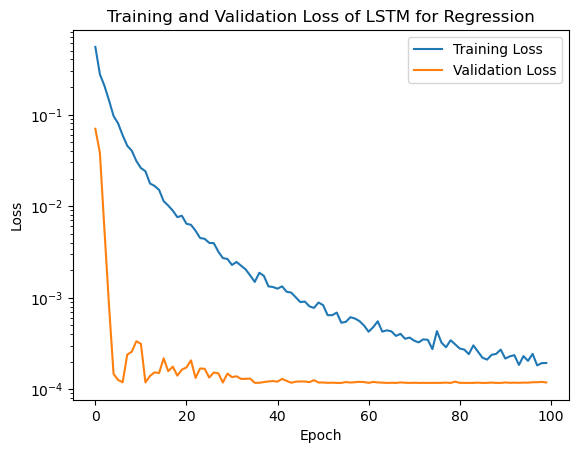

In [47]:
plt.title('Training and Validation Loss of LSTM for Regression')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()


In [48]:
_ = result_nn(
    lstm_reg,
    'LSTM (Regression)',
    X_tr=X_train_nn,
    y_tr=y_train_nn,
    X_te=X_test_nn,
    y_te=y_test_nn,
)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6815e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2900e-05 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
LSTM (Regression) Train MSE: 0.0001305853365920484
LSTM (Regression) Test MSE: 5.119918205309659e-05
LSTM (Regression) Train RMSE: 0.01142739412954889
LSTM (Regression) Test RMSE: 0.007155360371993614


### 4.3 Convolutional Neural Network (CNN)

In [49]:
num_features = X_train_nn.shape[2]  # number of columns in original dataset

CNN1D_reg = Sequential([
    Conv1D(
        filters=64,
        kernel_size=5,
        activation='relu',
        padding='same',
        input_shape=(sequence_length, num_features),
    ),
    MaxPooling1D(pool_size=2),
    Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    ),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1),
])

CNN1D_reg.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

history = CNN1D_reg.fit(
    X_train_nn,
    y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

CNN1D_reg.save('CNN1D_reg.keras')


Epoch 1/100


C:\Users\zln92\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1447449344.0000 - val_loss: 6036.1299 - learning_rate: 0.1000
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 819.7986 - val_loss: 72.9835 - learning_rate: 0.1000
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.2172 - val_loss: 0.7078 - learning_rate: 0.1000
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1930 - val_loss: 0.4386 - learning_rate: 0.1000
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 - val_loss: 0.1091 - learning_rate: 0.1000
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0432 - learning_rate: 0.1000
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.2549 - learning_rate: 0.1000
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0231 - learning_rate: 0.1000
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.0348 - learning_rate: 0.1000
Epoch 10/100
37

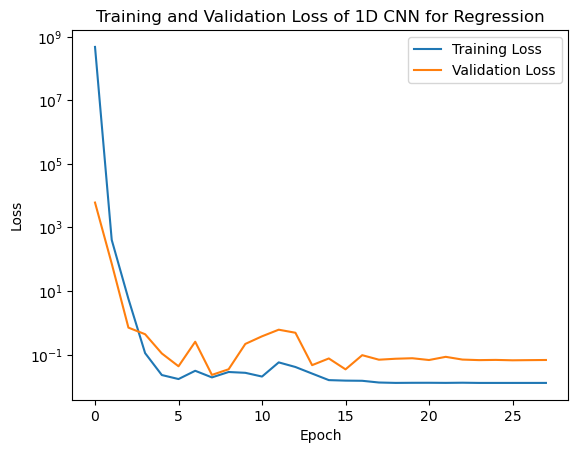

In [50]:
plt.title('Training and Validation Loss of 1D CNN for Regression')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()


In [51]:
_ = result_nn(
    CNN1D_reg,
    '1D CNN (Regression)',
    X_tr=X_train_nn,
    y_tr=y_train_nn,
    X_te=X_test_nn,
    y_te=y_test_nn,
)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1D CNN (Regression) Train MSE: 0.01970905438065529
1D CNN (Regression) Test MSE: 0.07369030267000198
1D CNN (Regression) Train RMSE: 0.14038893966639712
1D CNN (Regression) Test RMSE: 0.27145957833534257


### 4.4 CNN LSTM

In [52]:
CNN1D_lstm_reg = Sequential([
    Conv1D(
        filters=64,
        kernel_size=5,
        activation='relu',
        padding='same',
        input_shape=(sequence_length, num_features),
    ),
    MaxPooling1D(pool_size=2),
    Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    ),
    MaxPooling1D(pool_size=2),
    LSTM(32, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1),
])

CNN1D_lstm_reg.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

history = CNN1D_lstm_reg.fit(
    X_train_nn,
    y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

CNN1D_lstm_reg.save('CNN1D_lstm_reg.keras')


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8922 - val_loss: 0.0024 - learning_rate: 0.1000
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 1.2201e-04 - learning_rate: 0.1000
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5326e-04 - val_loss: 1.1884e-04 - learning_rate: 0.1000
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5140e-04 - val_loss: 1.2202e-04 - learning_rate: 0.1000
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2620e-04 - val_loss: 1.2179e-04 - learning_rate: 0.1000
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4153e-04 - val_loss: 1.3648e-04 - learning_rate: 0.1000
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4528e-04 - val_loss: 1.1876e-04 - learning_rate: 0.1000
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2227e-04 - val_loss: 1.1712e-04 - learning_rate: 0.0100
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1566e-04 - val

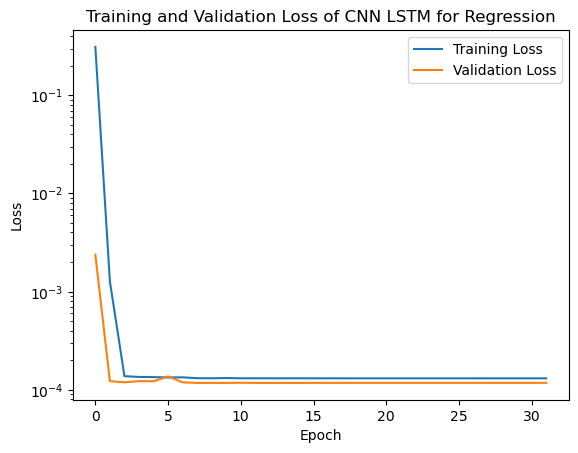

In [53]:
plt.title('Training and Validation Loss of CNN LSTM for Regression')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()


In [54]:
_ = result_nn(
    CNN1D_lstm_reg,
    'CNN LSTM (Regression)',
    X_tr=X_train_nn,
    y_tr=y_train_nn,
    X_te=X_test_nn,
    y_te=y_test_nn,
)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6813e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2670e-05 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
CNN LSTM (Regression) Train MSE: 0.00013050153211224824
CNN LSTM (Regression) Test MSE: 5.0988739531021565e-05
CNN LSTM (Regression) Train RMSE: 0.011423726717330393
CNN LSTM (Regression) Test RMSE: 0.007140639994497802


## 5. Model Comparison and Discussion

### 5.1 Comparison of RMSE

First, we compare the training and testing RMSE of the 8 models we've trained. We use RMSE as criterion.

In [55]:
# Load saved models for comparison
lin_reg_c = joblib.load('selector_lin_reg_cv.joblib')
dt_c = joblib.load('selector_dt.joblib')
rf_c = joblib.load('selector_rf.joblib')
xgb_c = joblib.load('selector_xgb.joblib')
mlp_c = load_model('MLP_reg.keras')
lstm_c = load_model('lstm_reg.keras')
cnn_c = load_model('CNN1D_reg.keras')
cnn_lstm_c = load_model('CNN1D_lstm_reg.keras')

model_list = [
    'baseline',
    lin_reg_c,
    dt_c,
    rf_c,
    xgb_c,
    mlp_c,
    lstm_c,
    cnn_c,
    cnn_lstm_c,
]

model_names = [
    'Baseline',
    'Linear Regression',
    'Decision Tree',
    'Random Forest',
    'XGBoost',
    'MLP',
    'LSTM',
    '1D CNN',
    'CNN LSTM',
]


In [56]:
df_model_comparison = pd.DataFrame(
    columns=[
        'model',
        'model_name',
        'train_MSE',
        'test_MSE',
        'train_RMSE',
        'test_RMSE',
        'y_test_predict',
    ]
)

df_model_comparison['model'] = model_list
df_model_comparison['model_name'] = model_names

df_model_comparison.iloc[0, 2:6] = (
    baseline_mse_train_final,
    baseline_mse_test_final,
    baseline_rmse_train_final,
    baseline_rmse_test_final,
)
df_model_comparison.iat[0, 6] = baseline_test_predict

for i in range(1, 5):
    df_model_comparison.iloc[i, 2:6] = selector_result(
        df_model_comparison.loc[i, 'model'], print_out=False
    )
    df_model_comparison.iat[i, 6] = selector_result(
        df_model_comparison.loc[i, 'model'], print_out=False, predict=True
    )

df_model_comparison.iloc[5, 2:6] = result_nn(
    df_model_comparison.loc[5, 'model'], print_out=False
)
df_model_comparison.iat[5, 6] = result_nn(
    df_model_comparison.loc[5, 'model'], print_out=False, predict=True
)

for i in range(6, 9):
    df_model_comparison.iloc[i, 2:6] = result_nn(
        df_model_comparison.loc[i, 'model'],
        model_name='',
        X_tr=X_train_nn,
        y_tr=y_train_nn,
        X_te=X_test_nn,
        y_te=y_test_nn,
        print_out=False,
    )
    df_model_comparison.iat[i, 6] = result_nn(
        df_model_comparison.loc[i, 'model'],
        model_name='',
        X_tr=X_train_nn,
        y_tr=y_train_nn,
        X_te=X_test_nn,
        y_te=y_test_nn,
        print_out=False,
        predict=True,
    )

df_model_comparison['y_test_predict'] = df_model_comparison['y_test_predict'].apply(
    lambda x: np.ravel(x)
)

df_model_comparison


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8159e-04 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8159e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6815e-04  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2900e-05 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6815e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2900e-05 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0319 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6813e-04  
13/13 ━━━━━━━━━━

,model,model_name,train_MSE,test_MSE,train_RMSE,test_RMSE,y_test_predict
0,baseline,Baseline,0.000127,0.000052,0.011283,0.007178,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"RFECV(cv=TimeSeriesSplit(gap=0, max_train_size...",Linear Regression,0.000126,0.000058,0.011231,0.007611,"[9.748103946616224e-05, 0.000582024958710533, ..."
2,"RFECV(cv=TimeSeriesSplit(gap=0, max_train_size...",Decision Tree,0.000094,0.000053,0.00969,0.007294,"[0.0003911573186231354, 0.0003911573186231354,..."
3,"RFECV(cv=TimeSeriesSplit(gap=0, max_train_size...",Random Forest,0.000105,0.000054,0.010224,0.00736,"[0.0019121735784212019, 0.0010096476163310333,..."
4,"RFECV(cv=TimeSeriesSplit(gap=0, max_train_size...",XGBoost,0.000106,0.000059,0.010296,0.007709,"[-0.004676743, 0.002464143, 0.0020128984, 0.00..."
5,"<Sequential name=sequential, built=True>",MLP,0.004358,0.001042,0.066016,0.032276,"[0.00056827633, 0.00056827633, 0.00056827633, ..."
6,"<Sequential name=sequential_1, built=True>",LSTM,0.000131,0.000051,0.011427,0.007155,"[0.00019381603, 0.00019381603, 0.00019381603, ..."
7,"<Sequential name=sequential_2, built=True>",1D CNN,0.019709,0.07369,0.140389,0.27146,"[0.15607905, 0.14068294, 0.13164973, 0.1305968..."
8,"<Sequential name=sequential_3, built=True>",CNN LSTM,0.000131,0.000051,0.011424,0.007141,"[0.00035510492, 0.00035510492, 0.00035510492, ..."


We didn't find a proper method to set random states for neural network models, so you may get different results if you run the code again.

From the bar graph below, we can observe that there's no model that is significantly better than the baseline model.

Some testing RMSE is lower than the traing RMSE. The reason might be that our testing data not obtained by randomly sampling, and the testing data is substantially different from the training data, according to our UMAP analysis in section 1.3.1.

From the table above, we can see that the predicted values some models including the neural network models are constants. They may just predict the rate of change to be the daily average rate of change. So, these model fails to grasp the increasing or decreasing trend of the Nasdaq Index.

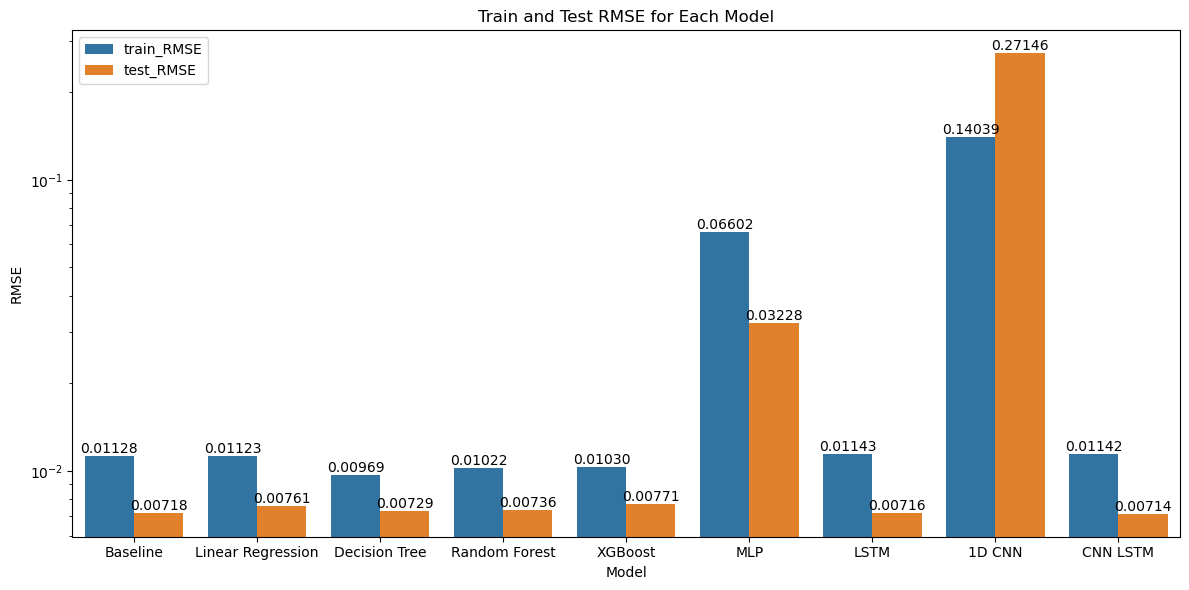

In [57]:
# Melt the dataframe to have train_MSE and test_MSE in one column
df_melted = df_model_comparison.melt(
    id_vars=['model_name'],
    value_vars=['train_RMSE', 'test_RMSE'],
    var_name='RMSE_Type',
    value_name='RMSE_Value',
)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the bars side by side using hue
ax = sns.barplot(
    x='model_name', y='RMSE_Value', hue='RMSE_Type', data=df_melted
)

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.5f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        rotation=0,
    )

# Add labels and title
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE for Each Model')
plt.xticks(rotation=0)
plt.yscale('log')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### 5.2 Predicting Nasdaq Index

In [58]:
# Keep only 'Close' and 'Close_day-1' columns in df_compare
df_compare = df.iloc[split_index:][['Close', 'Close_day-1']]

for i in range(9):
    model_name = df_model_comparison.loc[i, 'model_name']
    y_test_predict = df_model_comparison.loc[i, 'y_test_predict']
    df_compare[model_name] = df_compare['Close_day-1'] * (1 + y_test_predict)

df_compare


,Close,Close_day-1,Baseline,Linear Regression,Decision Tree,Random Forest,XGBoost,MLP,LSTM,1D CNN,CNN LSTM
1598,4750.209961,4736.160156,4736.160156,4736.621842,4738.012740,4745.216516,4714.010275,4738.851577,4737.078186,5475.375552,4737.842082
1599,4809.879883,4750.209961,4750.209961,4752.974702,4752.068040,4755.005999,4761.915311,4752.909366,4751.130715,5418.483444,4751.896877
1600,4760.689941,4809.879883,4809.879883,4814.637871,4811.761303,4810.711296,4819.561444,4812.613197,4810.812203,5443.099283,4811.587989
1601,4737.330078,4760.689941,4760.689941,4765.626611,4762.552120,4763.370205,4807.241778,4763.395302,4761.612726,5382.421176,4762.380579
1602,4717.680176,4737.330078,4737.330078,4738.565476,4739.183119,4740.332310,4706.732521,4740.022164,4738.248335,5437.549106,4739.012420
...,...,...,...,...,...,...,...,...,...,...,...
1979,6750.049805,6789.120117,6789.120117,6763.667137,6791.775731,6785.791067,6793.182125,6792.978175,6790.436081,9504.084121,6791.531100
1980,6750.939941,6750.049805,6750.049805,6723.597959,6752.690136,6748.439763,6762.724141,6753.885660,6751.358196,9488.322709,6752.446913
1981,6757.600098,6750.939941,6750.939941,6725.801424,6753.580621,6741.231789,6756.923441,6754.776302,6752.248505,9552.616779,6753.337365
1982,6737.870117,6757.600098,6757.600098,6730.846650,6760.243383,6756.024509,6767.336201,6761.440244,6758.909953,9578.126533,6759.999887


We can see that most model follows closely to the true value, while some model substantially deviate from the true value.

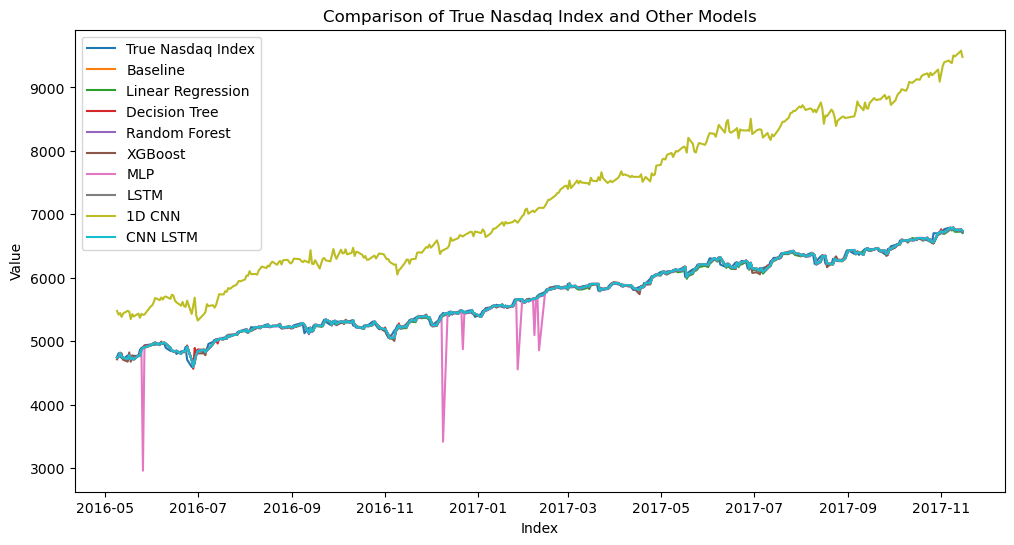

In [59]:
test_dates = df_raw.loc[y_test.index, 'Date']

plt.figure(figsize=(12, 6))

for column in df_compare.columns:
    if column not in ['Close_day-1']:
        label = "True Nasdaq Index" if column == "Close" else column
        plt.plot(test_dates, df_compare[column], label=label)

plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of True Nasdaq Index and Other Models")
plt.show()


### 5.3 Investment Simulation

Invest & Hold Final Cumulative Return: 1.4160
Baseline Strategy Final Cumulative Return: 1.4160
Linear Regression Strategy Final Cumulative Return: 0.8317
Decision Tree Strategy Final Cumulative Return: 1.3419
Random Forest Strategy Final Cumulative Return: 0.8919
XGBoost Strategy Final Cumulative Return: 1.2267
MLP Strategy Final Cumulative Return: 1.3785
LSTM Strategy Final Cumulative Return: 1.4160
1D CNN Strategy Final Cumulative Return: 1.4160
CNN LSTM Strategy Final Cumulative Return: 1.4160


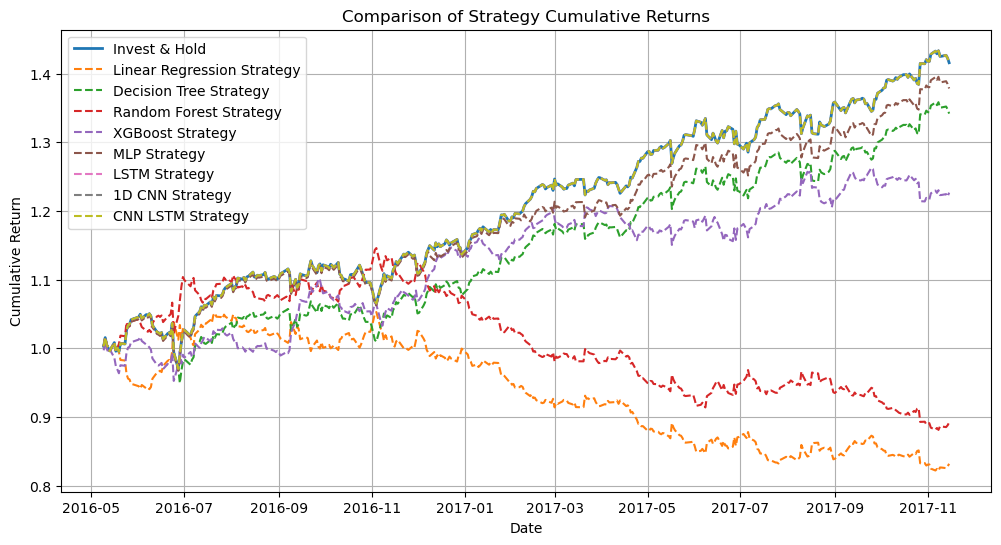

In [60]:
# ---------------------------------------------------------------
# Compute the true daily return using the 'Close' and 'Close_day-1' columns.
# Daily return is defined as (Close / Close_day-1) - 1.
# ---------------------------------------------------------------
df_compare['y_test'] = df_compare['Close'] / df_compare['Close_day-1'] - 1

# ---------------------------------------------------------------
# Calculate the cumulative return for the baseline (Invest & Hold) strategy.
# Invest & Hold: simply holding the asset, so cumulative return is the
# cumulative product of (1 + true daily return).
# ---------------------------------------------------------------
invest_hold_return = (1 + df_compare['y_test']).cumprod()

# ---------------------------------------------------------------
# Define a function to calculate cumulative strategy returns.
# For each day, if the predicted return (y_pred) is >= 0, we take a long
# position (+1); otherwise, a short position (-1). The strategy's daily
# return is then: position * true daily return.
# ---------------------------------------------------------------
def calc_strategy_returns(y_true, y_pred):
    # Determine position: long if predicted return >= 0, else short.
    position = np.where(y_pred >= 0, 1, -1)
    # Calculate daily strategy returns.
    daily_returns = position * y_true
    # Compute cumulative returns as the cumulative product of (1 + daily return).
    cum_returns = (1 + pd.Series(daily_returns, index=y_true.index)).cumprod()
    return cum_returns, daily_returns

# ---------------------------------------------------------------
# Create a dictionary to hold cumulative return series for each model.
# Loop over each model in df_model_comparison and compute its strategy returns.
# ---------------------------------------------------------------
strategy_returns = {}
for i in range(len(df_model_comparison)):
    model_name = df_model_comparison.loc[i, 'model_name']
    # Extract predicted returns for the test set and convert them to a Series 
    # with the same index as df_compare.
    y_pred = pd.Series(
        df_model_comparison.loc[i, 'y_test_predict'], index=df_compare.index
    )
    # Calculate the strategy cumulative returns using the true returns and predicted returns.
    strategy, _ = calc_strategy_returns(df_compare['y_test'], y_pred)
    strategy_returns[model_name] = strategy

# ---------------------------------------------------------------
# Print the final cumulative return for the Invest & Hold strategy and
# each model-based strategy.
# ---------------------------------------------------------------
print(
    "Invest & Hold Final Cumulative Return: {:.4f}".format(
        invest_hold_return.iloc[-1]
    )
)
for model_name, cum_return in strategy_returns.items():
    print(f"{model_name} Strategy Final Cumulative Return: {cum_return.iloc[-1]:.4f}")

# ---------------------------------------------------------------
# Plot the cumulative return curves for comparison.
# The Invest & Hold curve is plotted in a solid line.
# Each model strategy is plotted with a dashed line.
# ---------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(
    test_dates, invest_hold_return, label="Invest & Hold", linewidth=2
)
# Plot each model strategy except for the Baseline (since it's equivalent to Invest & Hold).
for model_name, cum_return in strategy_returns.items():
    if model_name != 'Baseline':
        plt.plot(
            test_dates,
            cum_return,
            label=f"{model_name} Strategy",
            linestyle="--"
        )
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Comparison of Strategy Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


We can see that no model is significantly better than the simple "invest and hold" strategy. The neural network models closely follows the baseline strategy because their predictions for rate of change are positive constants.

## 6. Conclusion

Although we didn't find any model that successfully predict the Nasdaq index, we showed that, using this dataset, we cannot use the linear regression, tree based models, and neural network models with the hyperparameter we've tried to predict Nasdaq index.

Predicting the financial market and make profit is not an easy task, but machine learning and deep learning is promising tool to do it. We can explore other available data, models, optimization methods to make successful prediction in the future.

## Reference

1. CNNpred: CNN-based stock market prediction using a diverse set of variables https://archive.ics.uci.edu/dataset/554/cnnpred+cnn+based+stock+market+prediction+using+a+diverse+set+of+variables
2. The idea of RFE and Time Series Cross-Validation are coming from ChatGPT and DeepSeek. The investment simulation part is modified from ChatGPT. Used ChatGPT to check the PEP8 format.
3. Martingale (probability theory) https://en.wikipedia.org/wiki/Martingale_(probability_theory)
4. Recursive feature elimination with cross-validation https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0931ec6e-a024-4399-8459-27f67845c293' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>